In [1]:
# torch related imports
import torch
import torch.nn as nn
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import torch.optim as optim 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid 
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F

# Lightning
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

# imports for hyperparam tuning with Ray
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## Data Analytics

In [ ]:
def analytics(dataset_train, dataset_val, dataset_test):
    # print sizes of datasets
    print(f'Size of train dataset: {len(dataset_train)}')
    print(f'Size of validation dataset: {len(dataset_val)}')
    print(f'Size of test dataset: {len(dataset_test)}')

    # plot distribution of each data set
    labels = ["normal", "pneumonia"]
    labels_num = [0,1]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
    
    # Bar for training
    pneumonia = np.count_nonzero(dataset_train.targets)
    normal = len(dataset_train.targets) - pneumonia
    ax1.bar(labels_num, [normal,pneumonia])
    ax1.set_xticks(labels_num, labels)
    ax1.set_title("Distribution of training set")
    ylim = ax1.get_ylim()
    
    # Bar for testing
    pneumonia = np.count_nonzero(dataset_test.targets)
    normal = len(dataset_test.targets) - pneumonia
    ax2.bar(labels_num, [normal,pneumonia])
    ax2.set_xticks(labels_num, labels)
    ax2.set_title("Distribution of test set")
    ax2.set_ylim(ylim)
    
    # Bar for validation
    pneumonia = np.count_nonzero(dataset_val.targets)
    normal = len(dataset_val.targets) - pneumonia
    ax3.bar(labels_num, [normal,pneumonia])
    ax3.set_xticks(labels_num, labels)
    ax3.set_title("Distribution of validation set")
    #ax2.set_ylim(ylim)

## Load Data

In [24]:
def loaddata(batchSize, dataDir = "/Project/chest_xray", useSampler = False, showAnalytics = False):
    data_dir_train = dataDir + "/train"
    data_dir_val = dataDir + "/val"
    data_dir_test = dataDir + "/test"

    NUM_WORERS = 7 # 7 because that what it suggested in a warning message
    PERSISTENT_WORKERS = True # Suggested to do this in a warning message for fatser init

    # Some desired transforms for ResNet50
    # https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
    train_transform = transforms.Compose(
        [
            transforms.Resize(size = (256, 256)),
            transforms.CenterCrop(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # 
        ]
    )

    dataset_train = datasets.ImageFolder(data_dir_train, train_transform)
    dataset_val = datasets.ImageFolder(data_dir_val, train_transform)
    dataset_test = datasets.ImageFolder(data_dir_test, transforms.ToTensor())

    if showAnalytics:
        analytics(dataset_train, dataset_val, dataset_test)

    if useSampler:
        labels = dataset_train.targets
        class_sample_count = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        
        # use WeightedRandomSampler as dataset is not balanced
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in labels])
        
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
        train_loader = DataLoader(
            dataset_train, 
            batch_size=batchSize, 
            shuffle=False, 
            num_workers=NUM_WORERS, 
            persistent_workers= PERSISTENT_WORKERS,
            sampler = sampler
            )
    else:
        train_loader = DataLoader(
            dataset_train, 
            batch_size=batchSize, 
            shuffle=True, 
            num_workers=NUM_WORERS, 
            persistent_workers= PERSISTENT_WORKERS
            )
        
    val_loader = DataLoader(
        dataset_val, 
        batch_size=batchSize, 
        shuffle=False, 
        num_workers=NUM_WORERS, 
        persistent_workers= PERSISTENT_WORKERS
    )
    test_loader = DataLoader(
        dataset_test, 
        batch_size=batchSize, 
        shuffle=False, 
        num_workers=NUM_WORERS, 
        persistent_workers= PERSISTENT_WORKERS
    )

    return train_loader, val_loader, test_loader
    

Size of train dataset: 5216
Size of validation dataset: 16
Size of test dataset: 624


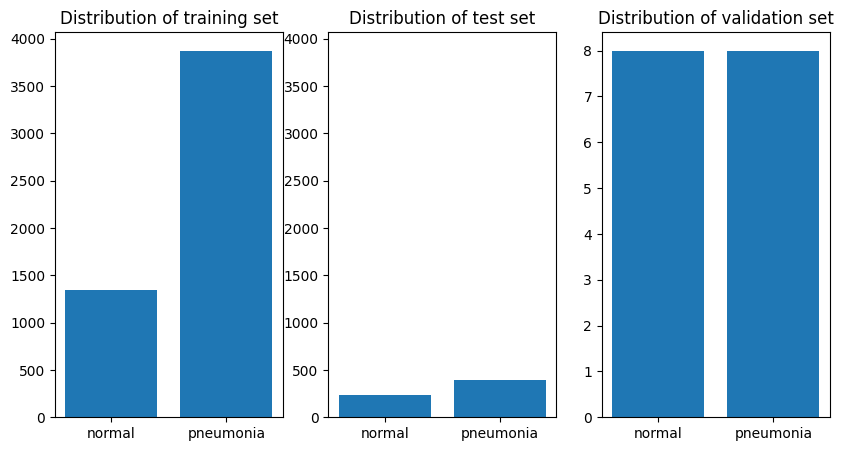

In [26]:
# show analytics
train_loader, _, _ = loaddata(showAnalytics = True, batchSize = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


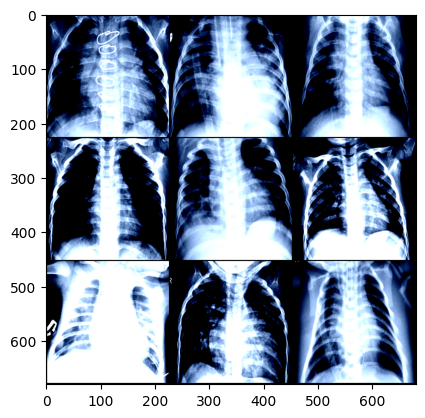

In [27]:
#Plot some example images
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))

## CNN model

In [28]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size) 
        self.pooling_layer = nn.MaxPool2d(2,2)
    def forward(self, x):
        x = self.conv_layer(x)
        x = nn.ReLU()(x)
        x = self.pooling_layer(x)
        return x 

In [29]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        # Assuming input_shape=(224,224,3) and padding = 0
        self.feature_extractor = nn.Sequential(
            ConvBlock(3,64,(3,3)), # 222,222,64 -> 111,111,64
            ConvBlock(64,128,(3,3)), #109,109,128 -> 54,54,128
            ConvBlock(128,256,(3,3)), # 52,52,256 -> 26,26,256
            ConvBlock(256,512,(3,3)) # 24,24,512 -> 12,12,512
        )
        self.flatten = nn.Flatten() # 12*12*512
        self.classification_head = nn.Sequential(
            nn.Linear(in_features=12*12*512, out_features=64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=32, out_features=num_classes)
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classification_head(x)
        return x

## Lightning Module

In [36]:
class Model(L.LightningModule):
    def __init__(self, config, num_classes = 2):
        super().__init__()
        self.cnn = CNN(num_classes)
        self.save_hyperparameters(ignore=['cnn'])
        self.lr = config["lr"]
        
        if config["loss"] == "BCEwLogits":
            def bcewl(y_est, y_true):
                return F.binary_cross_entropy_with_logits(y_est,
                                                          F.one_hot(y_true, num_classes).type(torch.float))
            self.loss = bcewl
        elif config["loss"] == "CrossEntropyLoss":
            self.loss = nn.CrossEntropyLoss()
        else:
            raise NotImplementedError(f"Loss {config['loss']} not implemented")
        
        metrics = MetricCollection([
            BinaryAccuracy(),
            BinaryF1Score(),
            BinaryPrecision(),
            BinaryRecall()
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        
    def forward(self, x):
        output = self.cnn(x)
        return output
    
    def training_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        loss = self.loss(preds, labels)
        self.train_metrics.update(torch.argmax(preds, dim=1), labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=images.shape[0])
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        loss = self.loss(preds, labels)
        self.val_metrics.update(torch.argmax(preds, dim=1), labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, batch_size=images.shape[0])
        return loss
    
    def on_train_epoch_end(self):
        performance = self.train_metrics.compute()
        self.log_dict(performance)
        self.train_metrics.reset()
        
    def on_validation_epoch_end(self):
        performance = self.val_metrics.compute()
        self.log_dict(performance)
        self.val_metrics.reset()   
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
        

In [ ]:
MAX_EPOCHS = 50

In [37]:
def train_func(config):
    train_loader, val_loader, test_loader = loaddata(batchSize=config["batch_size"])
    model = Model(config)

    early_stopping = L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-6)
    checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath='pneumonia_model/', monitor="val_BinaryAccuracy", mode='max')
    callbacks = [early_stopping, checkpoint, RayTrainReportCallback()]
    logger = TensorBoardLogger("../tf/logs", name="simple_CNN")

    trainer = L.Trainer(
        max_epochs= MAX_EPOCHS,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=callbacks,
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
        logger = logger
    )

    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    trainer = prepare_trainer(trainer)
    trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=val_loader)

In [38]:
search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([4, 16, 32, 64]),
    "loss" : tune.choice(["BCEwLogits", "CrossEntropyLoss"]),
    "dropout": tune.choice([0.0, 0.5, 0.8]), # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10518240/pdf/cureus-0015-00000044130.pdf
}

# The maximum training epochs
num_epochs = MAX_EPOCHS

# Number of sampls from parameter space
num_samples = 10


In [47]:
scaling_config = ScalingConfig(
    num_workers=2, use_gpu=True
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_BinaryAccuracy",
        checkpoint_score_order="max",
    ),
)

In [48]:
# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [49]:
def tuning(num_samples=10, num_epochs=5):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val_BinaryAccuracy",
            mode="max",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()


results = tuning(num_samples=num_samples, num_epochs=num_epochs)

2024-05-13 10:58:40,920	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 1.0 CPUs and 2.0 GPUs per trial, but the cluster only has 64.0 CPUs and 1.0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.
2024-05-13 10:59:12,139	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-05-13 10:59:12,146	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is 

In [ ]:
results.get_best_result(metric="val_BinaryAccuracy", mode="max")